# Sclera segmentation and sclera color value estimation to be used for color correction and skin tone estimation models

In [ ]:
import mediapipe as mp
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import cv2
import json

sys.path.append('/home/dasec-notebook/Thesis/skin_tone_estimation')

from utils import sclera_segmentation_utils 
from utils import color_correction_utils

sys.path.append('/home/dasec-notebook/Thesis/sclera-segmentation/src')

import sclera # NOTE: This is the custom module for sclera segmentation taken from https://github.com/wkabbani/sclera-segmentation

%load_ext autoreload
%autoreload 2

In [19]:
image_path_file = "../image_paths/test_images.txt"
degub_directory = "debug_images"

# Load the image paths
with open(image_path_file, "r") as f:
    image_paths = f.readlines()

In [ ]:
# Generate the face mesh for images in the txt file

mp_face_mesh = mp.solutions.face_mesh

for image_path in image_paths:
    image_path = image_path.strip()

    debug_path = f"{degub_directory}/{image_path.split('/')[-1]}"
    print(debug_path)
    l_locations, r_locations = sclera.get_sclera_location(
        mp_face_mesh, image_path, debug_path=debug_path
    )

    if l_locations and r_locations:
        l_values, r_values = sclera.get_sclera_pixels(
            image_path, l_locations, r_locations
        )

    print(len(l_values))
    print(len(r_values))

## Plot example of one person with a masked image

mask shape (558, 501, 3)


I0000 00:00:1733310051.126255   16695 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733310051.127318   24298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: Mesa Intel(R) HD Graphics 620 (KBL GT2)
W0000 00:00:1733310051.130990   24295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733310051.155451   24295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


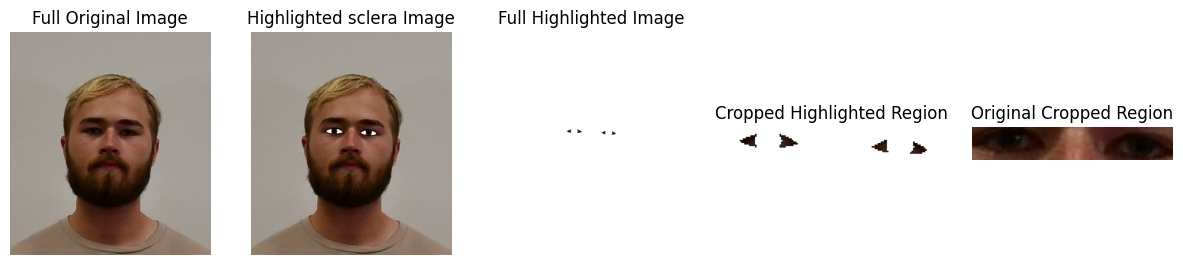

In [21]:
mp_face_mesh = mp.solutions.face_mesh

debug_path = "test_image2.jpg"
image_path = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2/00067/DSC_0593.JPG"

l_locations, r_locations = sclera.get_sclera_location(
    mp_face_mesh, image_path, debug_path=debug_path
)

if l_locations and r_locations:
    l_values, r_values = sclera.get_sclera_pixels(image_path, l_locations, r_locations)

# Plot the segmentation
image = Image.open(image_path)
image = np.array(image)
mask = np.zeros(image.shape, dtype=bool)

for loc in l_locations + r_locations:
    x, y = loc
    mask[y, x] = True

print("mask shape", mask.shape)


highlighted_image = image.copy()
highlighted_image[~mask] = 255  # NOTE: This is the color for the mask pixels

# Save the image with the sclera pixels highlighted
highlighted_image = Image.fromarray(highlighted_image)
highlighted_image.save("highlighted_sclera2.jpg")


# Plot a small region of the sclera
sclera_coords = np.column_stack(np.where(mask[..., 0]))

y_min, x_min = sclera_coords.min(axis=0)
y_max, x_max = sclera_coords.max(axis=0)

# Add a margin to the bounding box
margin = 5
y_min = max(y_min - margin, 0)
x_min = max(x_min - margin, 0)
y_max = min(y_max + margin, image.shape[0])
x_max = min(x_max + margin, image.shape[1])

if isinstance(highlighted_image, Image.Image):
    highlighted_image = np.array(highlighted_image)

cropped_region = highlighted_image[y_min:y_max, x_min:x_max]
original_cropped_region = image[y_min:y_max, x_min:x_max]

# Save the cropped region
# cropped_region_pil = Image.fromarray(cropped_region)
# cropped_region_pil.save('highlighted_sclera_cropped.jpg')

# Display the images for visualization
plt.figure(figsize=(15, 7))

plt.subplot(1, 5, 1)
plt.title("Full Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 5, 2)
plt.title("Highlighted sclera Image")
debug_image = Image.open(debug_path)
debug_image = np.array(debug_image)
plt.imshow(debug_image)
plt.axis("off")

plt.subplot(1, 5, 3)
plt.title("Full Highlighted Image")
plt.imshow(highlighted_image)
plt.axis("off")


plt.subplot(1, 5, 4)
plt.title("Cropped Highlighted Region")
plt.imshow(cropped_region)
plt.axis("off")

plt.subplot(1, 5, 5)
plt.title("Original Cropped Region")
plt.imshow(original_cropped_region)
plt.axis("off")

plt.show()

# Visualize the average sclera color for each person in the xyY color space

Based on the original images

In [ ]:
image_paths_txt = (
    "/home/dasec-notebook/Thesis/skin_tone_estimation/image_paths/indoor.txt"
)
image_paths = open(image_paths_txt, "r").readlines()

debug_directory = None
person_xyY = []

for image_path in image_paths:
    image_path = image_path.strip()
    debug_path = f"{debug_directory}/{image_path.split('/')[-1]}"

    l_locations, r_locations = sclera.get_sclera_location(
        mp_face_mesh, image_path, debug_path=debug_path
    )

    if l_locations and r_locations:
        avg_xyY = sclera_segmentation_utils.get_average_sclera_color(
            image_path, l_locations, r_locations
        )
        person_xyY.append(avg_xyY)

person_xyY = np.array(person_xyY)

plt.figure(figsize=(8, 6))
plt.scatter(
    person_xyY[:, 0], person_xyY[:, 1], c=person_xyY[:, 2], cmap="viridis", s=100
)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sclera Color Distribution in xyY Color Space")
plt.colorbar(label="Y (Brightness)")
plt.xlim(0.25, 0.55)
plt.ylim(0.25, 0.55)
plt.grid(True)
plt.show()

# Extract sclera RGB and save to JSON

In [ ]:
dataset_path = "/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction/exposure_color_correction"
sclera_RGB_json_output = "/home/dasec-notebook/Thesis/skin_tone_estimation/sclera_segmentation/results/CHROMA-FIT_exposure_color_correction_sclera_RGB.json"

results = {}

mp_face_mesh = mp.solutions.face_mesh

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg", ".JPG")):

            image_path = os.path.join(root, file)
            relative_path = os.path.relpath(image_path, dataset_path)

            folder_name, file_name = os.path.split(relative_path)
            folder_name = folder_name.replace("\\", "/")

            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read {image_path}. Skipping.")
                continue

            height, width, _ = image.shape

            # Get sclera locations
            l_locations, r_locations = sclera.get_sclera_location(
                mp_face_mesh, image_path
            )

            if not (l_locations and r_locations):
                print(f"Warning: Sclera locations not found in {image_path}. Skipping.")
                continue

            l_locations = sclera_segmentation_utils.clip_coordinates(
                l_locations, height, width
            )
            r_locations = sclera_segmentation_utils.clip_coordinates(
                r_locations, height, width
            )

            # Extract sclera pixel values
            l_values, r_values = sclera.get_sclera_pixels(
                image_path, l_locations, r_locations
            )

            # Perform Otsu segmentation
            l_eye_mask = color_correction_utils.create_eye_mask_otsu(
                l_locations, l_values, height, width
            )
            r_eye_mask = color_correction_utils.create_eye_mask_otsu(
                r_locations, r_values, height, width
            )
            otsu_mask = cv2.bitwise_or(l_eye_mask, r_eye_mask)

            otsu_sclera_coords = np.column_stack(np.where(otsu_mask != 0))

            # Convert to RGB for processing
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Calculate average color for each eye
            l_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
                image, l_eye_mask, patch_size=5
            )
            r_otsu_moving_avg_rgb = color_correction_utils.masked_moving_average(
                image, r_eye_mask, patch_size=5
            )

            l_otsu_moving_avg_rgb = [
                int(round(value)) for value in l_otsu_moving_avg_rgb
            ]
            r_otsu_moving_avg_rgb = [
                int(round(value)) for value in r_otsu_moving_avg_rgb
            ]

            # l_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, l_eye_mask, color_correction_utils.calculate_coords(l_eye_mask), window_size=1, stride=1
            # )
            # r_otsu_moving_avg_rgb = color_correction_utils.calculate_patch_avg_color(
            #     image, r_eye_mask, color_correction_utils.calculate_coords(r_eye_mask), window_size=1, stride=1
            # )

            # Proceed if at least one average is valid
            if l_otsu_moving_avg_rgb is not None or r_otsu_moving_avg_rgb is not None:
                # Default to the available values for calculations
                if l_otsu_moving_avg_rgb is None:
                    l_otsu_moving_avg_rgb = None
                    print(
                        f"Warning: Left eye average not found in {image_path}. Value is set to None."
                    )
                if r_otsu_moving_avg_rgb is None:
                    r_otsu_moving_avg_rgb = None
                    print(
                        f"Warning: Right eye average not found in {image_path}. Value is set to None."
                    )

                    # Calculate the average sclera color, considering None values
                avg_sclera_color = [
                    (
                        (l if l is not None else r)
                        if (l is None or r is None)
                        else (l + r) // 2
                    )
                    for l, r in zip(
                        (
                            l_otsu_moving_avg_rgb
                            if l_otsu_moving_avg_rgb is not None
                            else [None] * 3
                        ),
                        (
                            r_otsu_moving_avg_rgb
                            if r_otsu_moving_avg_rgb is not None
                            else [None] * 3
                        ),
                    )
                ]
            else:
                avg_sclera_color = None  # Both are None, so set the average to None

            # Populate the JSON structure
            if folder_name not in results:
                results[folder_name] = {}

            results[folder_name][file_name] = {
                "left_sclera_color": (
                    l_otsu_moving_avg_rgb if l_otsu_moving_avg_rgb is not None else None
                ),
                "right_sclera_color": (
                    r_otsu_moving_avg_rgb if r_otsu_moving_avg_rgb is not None else None
                ),
                "avg_sclera_color": (
                    avg_sclera_color if avg_sclera_color is not None else None
                ),
            }

results = sclera_segmentation_utils.convert_to_native_types(results)


with open(sclera_RGB_json_output, "w") as json_file:
    json.dump(results, json_file, indent=4)

print(f"Results saved to {sclera_RGB_json_output})")